# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

In [ ]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and True:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
find_path('DL_3_convnets')[0][0]

'/content/drive/MyDrive/Colab Notebooks/DL/DL_3_convnets'

In [ ]:
os.chdir(find_path('DL_3_convnets')[0][0])
os. getcwd()

'/content/drive/MyDrive/Colab Notebooks/DL/DL_3_convnets'

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="/content/drive/MyDrive/Colab Notebooks/DL/DL_3_convnets/cifar10.jpg" style="width:80%">

In [ ]:
# when running in colab, un-comment this
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


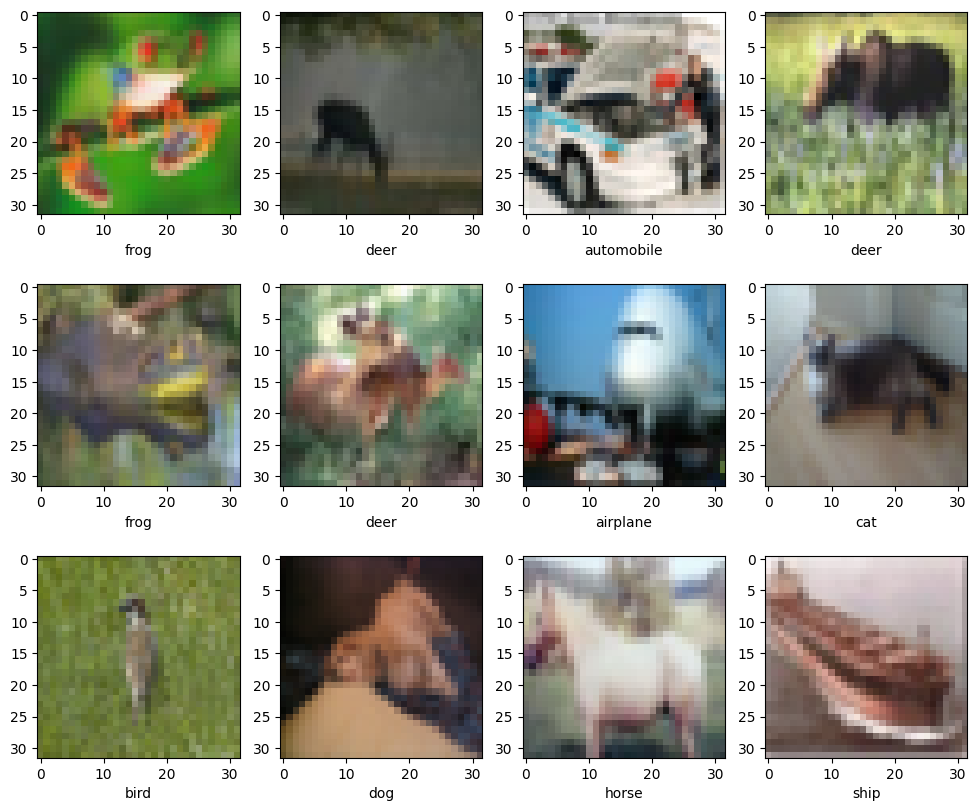

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
device = 'cuda'

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential(
    # input:  (batch) x 3 x 32 x 32
    nn.Conv2d(3, 16, kernel_size=(3, 3)),  # 16 x 30 x 30
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=(3, 3)), # 32 x 28 x 28
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=(2, 2)),      # 32 x 14 x 14
    nn.Conv2d(32, 64, kernel_size=(3, 3)), # 64 x 12 x 12
    nn.BatchNorm2d(64),
    Flatten(),
    nn.Linear(64 * 12 * 12, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

# reshape from "images" to flat vectors
# model.add_module('flatten', Flatten())  # 3, 32, 32

# # dense "head"
# model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
# model.add_module('dense1_relu', nn.ReLU())
#model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(model, X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    #print(logits)
    #print(y_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3949, device='cuda:0', grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

#train_loss = []
#val_accuracy = []

In [ ]:
import time
def train_model(model, opt, num_epochs=20, batch_size=50, X_train=X_train, y_train=y_train):
    #num_epochs = 100 # total amount of full passes over training data
    #num_epochs = 20 # total amount of full passes over training data
    #batch_size = 50  # number of samples processed in one SGD iteration
    train_loss = []
    val_accuracy = []

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.cpu().numpy())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
            y_pred = logits.max(1)[1].data.cpu().numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

NameError: ignored

In [ ]:
train_model(model, opt)

NameError: ignored

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
### Final test

In [ ]:
def final_test(model, X_test=X_test, y_test=y_test):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        test_batch_acc.append(np.mean(y_batch == y_pred))

    print('y_batch', y_batch)
    print('y_pred', y_pred)

    test_accuracy = np.mean(test_batch_acc)

    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

In [ ]:
final_test(model_task3, X_test=X_aug[:10], y_test=y_aug[:10])

y_batch tensor([9, 6, 5, 1, 9, 2, 8, 4, 6, 0])
y_pred [9 6 5 1 9 3 8 3 4 1]
Final results:
  test accuracy:		0.00 %
We need more magic! Follow instructons below


In [ ]:
final_test(model)

Final results:
  test accuracy:		56.77 %
Achievement unlocked: 60lvl Warlock!


## Task I: small convolution net

### First step
Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [ ]:
model_task1 = nn.Sequential(
    # input:  (batch) x 3 x 32 x 32
    nn.Conv2d(3, 10, kernel_size=(3, 3)),  # 10 x 30 x 30
    nn.ReLU(), # 10 x 30 x 30
    nn.MaxPool2d(kernel_size=(2, 2)), # 10 x 15 x 15
    Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10),
).to(device)

In [ ]:
opt_task1 = torch.optim.Adam(model_task1.parameters(), lr=0.001)

In [ ]:
train_model(model_task1, opt_task1, num_epochs=20)

Epoch 1 of 50 took 1.785s
  training loss (in-iteration): 	1.859545
  validation accuracy: 			41.00 %
Epoch 2 of 50 took 2.122s
  training loss (in-iteration): 	1.666066
  validation accuracy: 			42.40 %
Epoch 3 of 50 took 2.099s
  training loss (in-iteration): 	1.605649
  validation accuracy: 			42.50 %
Epoch 4 of 50 took 1.812s
  training loss (in-iteration): 	1.556528
  validation accuracy: 			42.21 %
Epoch 5 of 50 took 1.786s
  training loss (in-iteration): 	1.516298
  validation accuracy: 			42.20 %
Epoch 6 of 50 took 1.763s
  training loss (in-iteration): 	1.491644
  validation accuracy: 			44.38 %
Epoch 7 of 50 took 1.767s
  training loss (in-iteration): 	1.448869
  validation accuracy: 			44.32 %
Epoch 8 of 50 took 1.845s
  training loss (in-iteration): 	1.426507
  validation accuracy: 			43.80 %
Epoch 9 of 50 took 2.099s
  training loss (in-iteration): 	1.398159
  validation accuracy: 			43.29 %
Epoch 10 of 50 took 2.120s
  training loss (in-iteration): 	1.367615
  validation 

KeyboardInterrupt: ignored

In [ ]:
final_test(model_task1)

Final results:
  test accuracy:		47.38 %
We need more magic! Follow instructons below


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.


## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [ ]:
model_task2 = nn.Sequential(
    # input:  (batch) x 3 x 32 x 32
    nn.Conv2d(3, 10, kernel_size=(3, 3)),  # 10 x 30 x 30
    nn.BatchNorm2d(10),
    nn.ReLU(), # 10 x 30 x 30
    nn.MaxPool2d(kernel_size=(2, 2)), # 10 x 15 x 15
    Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
).to(device)

opt_task2 = torch.optim.Adam(model_task2.parameters(), lr=0.001)

In [ ]:
train_model(model_task2, opt_task2, num_epochs=20)

Epoch 1 of 20 took 1.960s
  training loss (in-iteration): 	1.535573
  validation accuracy: 			50.52 %
Epoch 2 of 20 took 1.937s
  training loss (in-iteration): 	1.280416
  validation accuracy: 			54.34 %
Epoch 3 of 20 took 1.964s
  training loss (in-iteration): 	1.168180
  validation accuracy: 			55.88 %
Epoch 4 of 20 took 1.948s
  training loss (in-iteration): 	1.086167
  validation accuracy: 			59.09 %
Epoch 5 of 20 took 2.400s
  training loss (in-iteration): 	1.015901
  validation accuracy: 			53.10 %
Epoch 6 of 20 took 2.325s
  training loss (in-iteration): 	0.964392
  validation accuracy: 			59.94 %
Epoch 7 of 20 took 1.914s
  training loss (in-iteration): 	0.913178
  validation accuracy: 			60.70 %
Epoch 8 of 20 took 1.916s
  training loss (in-iteration): 	0.868105
  validation accuracy: 			60.01 %
Epoch 9 of 20 took 1.946s
  training loss (in-iteration): 	0.829327
  validation accuracy: 			60.84 %
Epoch 10 of 20 took 1.919s
  training loss (in-iteration): 	0.801469
  validation 

In [ ]:
final_test(model_task2)

Final results:
  test accuracy:		59.23 %
Achievement unlocked: 60lvl Warlock!


## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=50,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([50, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([50])


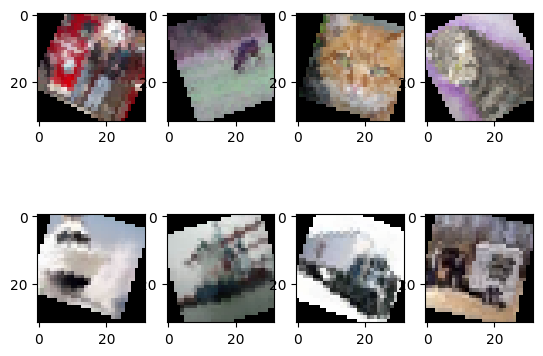

In [ ]:
for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        out = img.transpose([1,2,0]) * stds + means
        plt.imshow((out * 255).astype(np.uint8))
    break

Использование конструкции, увеличивает время обучения каждой эпохи в 10-15 раз (1 эпоха длиться 30 секунд) из-за того что dataLoader изменяет изображения прям во время обучения(когда достаем данные). Поэтому, что бы не тратить время будем формировать аугментированный датасет заранее.

``` for (x_batch, y_batch) in train_batch_gen:```
```
%time
X_aug = []
y_aug = []
i = 0
for (x_batch, y_batch) in train_batch_gen:
  if i==0:
    X_aug = x_batch
    y_aug = y_batch
    i+=1
  else:
    X_aug = torch.cat((X_aug, x_batch))
    y_aug = torch.cat((y_aug, y_batch))
```

In [ ]:
model_task3 = nn.Sequential(
    # input:  (batch) x 3 x 32 x 32
    nn.Conv2d(3, 10, kernel_size=(3, 3)),  # 10 x 30 x 30
    nn.BatchNorm2d(10),
    nn.ReLU(), # 10 x 30 x 30
    nn.MaxPool2d(kernel_size=(2, 2)), # 10 x 15 x 15
    Flatten(),
    nn.Linear(10 * 15 * 15, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
).to(device)

opt_task3 = torch.optim.Adam(model_task3.parameters(), lr=0.01)

In [ ]:
#num_epochs = 100 # total amount of full passes over training data
num_epochs = 20 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration
train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model_task3.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in train_batch_gen:
        # train on batch
        # loss
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
        y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch).mean()
        train_loss.append(loss.data.cpu().numpy())

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))

Epoch 1 of 20 took 28.445s
  training loss (in-iteration): 	2.056105
Epoch 2 of 20 took 28.708s
  training loss (in-iteration): 	2.057132
Epoch 3 of 20 took 28.091s
  training loss (in-iteration): 	2.058220
Epoch 4 of 20 took 28.587s
  training loss (in-iteration): 	2.055736


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7decfc881000>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7decfc881000>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 5 of 20 took 29.900s
  training loss (in-iteration): 	2.051641
Epoch 6 of 20 took 28.741s
  training loss (in-iteration): 	2.052426
Epoch 7 of 20 took 29.349s
  training loss (in-iteration): 	2.056330
Epoch 8 of 20 took 29.547s
  training loss (in-iteration): 	2.071324


KeyboardInterrupt: ignored

When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=50,
                                              shuffle=True,
                                              num_workers=1)

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in test_batch_gen:
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

y_batch tensor([9, 6, 1, 5, 4, 5, 0, 5, 8, 4, 8, 3, 6, 7, 5, 0, 7, 8, 3, 4, 8, 1, 9, 9,
        9, 9, 8, 4, 4, 6, 7, 4, 2, 2, 4, 5, 5, 5, 1, 6, 2, 4, 7, 4, 9, 9, 7, 9,
        5, 3])
y_pred [9 6 0 5 2 5 2 5 1 4 8 5 6 7 5 0 7 8 2 4 8 1 9 9 9 3 8 6 4 2 4 2 7 2 6 5 3
 5 1 5 0 3 7 7 9 2 2 8 5 3]
Final results:
  test accuracy:		56.05 %
Achievement unlocked: 60lvl Warlock!


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


# I do it in My_network.ipnb